# Advanced Machine Learning

### Assigment #7 - Time Series

**Team:**
    João Raimundo (57454), Rui Roque (57588)

### 0.1 Import Libraries

In [45]:
import math
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt
from IPython.display import Image


#from datetime import datetime

# tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
#from tensorflow.keras.models import Model

## 0.2 Defining functions for each model

In this stage we create a functions for the LSTM and FTLFN Models. <p>
In the functions we create the model, fit with the trainning data and the evaluation of the obtained results.

### 0.2.1. LSTM Model (Long short-term memory):

In [46]:
def lstm(X_train, y_train, X_test, y_test, epochs, noise = False, noise_value = 0.05):
    
    # model creation: layers + dropout + 12 neurons
    if(noise == False):
        lstm_model = Sequential([
        layers.LSTM(12, return_sequences=True),
        layers.Dropout(0.2),
        layers.LSTM(12, return_sequences=True),
        layers.Dropout(0.2),
        layers.LSTM(12),
        layers.Dropout(0.2),
        layers.Dense(1)
        ])
    else:
        lstm_model = Sequential([
        layers.GaussianNoise(noise_value),
        layers.LSTM(12, return_sequences=True),
        layers.Dropout(0.2),
        layers.LSTM(12, return_sequences=True),
        layers.Dropout(0.2),
        layers.LSTM(12),
        layers.Dropout(0.2),
        layers.Dense(1)
        ])    


    # compile
    lstm_model.compile(optimizer = 'adam', loss = keras.losses.MeanSquaredError(), metrics=[tf.metrics.MeanAbsoluteError()])

    print("LSTM Model contructed with 3 hidden layers of 12 neurons:\n")

    # Fitting the RNN to the Training set
    print("Currently fitting the model with the training set with", epochs, " epochs:")
    history_lstm = lstm_model.fit(X_train,y_train,epochs = epochs)

    print("\n")

    # plot loss plot
    plt.plot(history_lstm.history['loss'], label="loss")
    plt.legend(loc="upper right")
    plt.title("Loss Plot")
    plt.show()

    # inferring MSE % RMSE
    predictions = lstm_model.predict(X_test)
    test_score = mean_squared_error(y_test, predictions)
    print('LSTM Model Test MSE: %.3f' % test_score)
    print('LSTM Model Test RMSE: %.3f' % sqrt(test_score))

    # plot predictions and expected results
    fig = plt.figure(figsize=(40,10))
    plt.plot(y_train,  label="Train")
    plt.plot([None for i in y_train] + [x for x in y_test], label="Test")
    plt.plot([None for i in y_train] + [x for x in predictions], label="Predicted")
    plt.legend(loc="upper left", prop= {"size": 15}) 
    plt.xticks(fontsize = 15)
    plt.yticks(fontsize = 15)
    plt.title("Train, Test and Predicted Results")
    plt.show()


### 0.2.2. FTLFN Model:

In [47]:
def ftlfn(X_train, y_train, X_test, y_test, epochs, noise = False, noise_value = 0.05):

    # model creation: layers + dropout + 12 neurons
    if(noise == False):
        ftlfn_model = Sequential([
        layers.Dense(12, activation='relu'),
        layers.Dense(1)
        ])
    else:
        ftlfn_model = Sequential([
        layers.GaussianNoise(noise_value),
        layers.Dense(12, activation='relu'),
        layers.Dense(1)
        ])


    # compile
    ftlfn_model.compile(optimizer = 'adam', loss = keras.losses.MeanSquaredError(), metrics=[tf.metrics.MeanAbsoluteError()])

    # Fitting the RNN to the Training set
    print("Currently fitting the model with the training set with", epochs, " epochs:")

    train_performance, test_performance = list(), list()
    
    for i in range(epochs):
        history_ftlfn = ftlfn_model.fit(X_train,y_train,epochs = 1)
        
        train_performance.append(ftlfn_model.evaluate(X_train, y_train, verbose=0)[0])
        test_performance.append(ftlfn_model.evaluate(X_test_1, y_test_1, verbose = 0)[0])

    performance = pd.DataFrame()
    performance["train_mse"], performance["test_mse"] = train_performance, test_performance

    return performance
    

In [48]:
def run_ftlfn(X_train, y_train, X_test, y_test, repeats, epochs, noise = False, noise_value = 0.05):
    # constructing the feedforward network
    print("FTLFN Model contructed with 12 neurons:\n")

    aux=0
    for i in range(repeats):
        history = ftlfn(X_train, y_train, X_test, y_test, epochs)
        plt.plot(history['train_mse'], color='blue', label = "Train")
        plt.plot(history['test_mse'], color='orange', label = "Test")
        if aux == 0:
            plt.title("MSE for Train and Test Sets")
            plt.legend(loc="upper left", prop= {"size": 10}) 
            aux=1
        print('Repeat %d) TrainMSE=%f, TestMSE=%f' % (i, history['train_mse'].iloc[-1], history['test_mse'].iloc[-1]),"\n")

## Problem 1

We will observe the evolution of LSTM and FTLFN models learning rate process and compare their performances with (Gaussian N(0, 0.05)) and without noise, with diferent sets of the time series data points.

 * Epochs = 10

### 1.1. Creation of the time series 

We defined a time series with a sinusoidal function with 100 periods and 50 points per period with a time delay of 12.
We subset the timeseries dataset in two distinct manners, in order to evaluate the performances when performed with each model (LSTM and FTLFN):
  * The first 2400 data points and test with data points 2401 to 2500
  * Data points 2401 to 4900 and test with data points 4901 to 5000

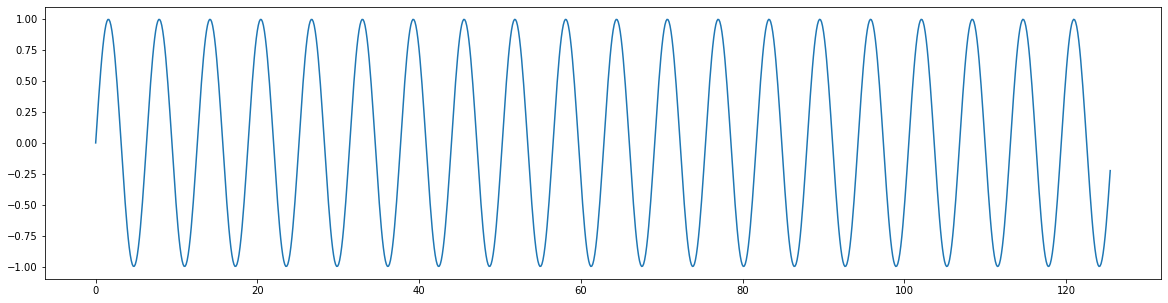

In [49]:
lag = 12
points = np.linspace(0, 2*math.pi*100, 50*100)
sin = np.sin(points)

fig = plt.figure(figsize=(20,5))


# plot the function - first 
plt.plot(points[0:999], sin[0:999])
plt.show()

Adding a filter (time delay) of 12 to the time series:

In [50]:
X = []
y = []

for i in range(lag, 4999):
   X.append(sin[i-lag:i])
   y.append(sin[i])

X = np.expand_dims(X, axis = 2)
y = np.array(y)

Split Data:

- Training with the first 2400 data points and testing with data points 2401 to 2501 (First split);
  
- Training from data points 2401 to 4900 and testing with data points 4901 to the last data point (Second split).

In [51]:
X_train_1 = X[:2400]
y_train_1 = y[:2400]
X_test_1  = X[2401:2501]
y_test_1  = y[2401:2501]

X_train_2 = X[2401:4900]
y_train_2 = y[2401:4900]
X_test_2  = X[4901:-1]
y_test_2  = y[4901:-1]

print("Shape of sets: \n")
print("--> First Split Train and Test sets:")
print("X_train_1: ", X_train_1.shape)
print("y_train_1: ", y_train_1.shape)
print("X_test_1: ", X_test_1.shape)
print("y_test_1: ", y_test_1.shape,"\n")

print("--> Second Split Train and Test sets:")
print("X_train_2: ", X_train_2.shape)
print("y_train_2: ", y_train_2.shape)
print("X_test_2: ", X_test_2.shape)
print("y_test_2: ", y_test_2.shape)

Shape of sets: 

--> First Split Train and Test sets:
X_train_1:  (2400, 12, 1)
y_train_1:  (2400,)
X_test_1:  (100, 12, 1)
y_test_1:  (100,) 

--> Second Split Train and Test sets:
X_train_2:  (2499, 12, 1)
y_train_2:  (2499,)
X_test_2:  (85, 12, 1)
y_test_2:  (85,)


 ### 1.2 Inferring the evolution of LSTM and FTLFN learning process without noise

### 1.2.1. LSTM Model

### 1.2.1.1 First split:

LSTM Model contructed with 3 hidden layers of 12 neurons:

Currently fitting the model with the training set with 10  epochs:
Epoch 1/10
75/75 [==============================] - 4s 8ms/step - loss: 0.3998 - mean_absolute_error: 0.5685
Epoch 2/10
75/75 [==============================] - 1s 7ms/step - loss: 0.1878 - mean_absolute_error: 0.3714
Epoch 3/10
75/75 [==============================] - 1s 7ms/step - loss: 0.0483 - mean_absolute_error: 0.1752
Epoch 4/10
75/75 [==============================] - 1s 7ms/step - loss: 0.0340 - mean_absolute_error: 0.1450
Epoch 5/10
75/75 [==============================] - 1s 7ms/step - loss: 0.0313 - mean_absolute_error: 0.1388
Epoch 6/10
75/75 [==============================] - 1s 7ms/step - loss: 0.0281 - mean_absolute_error: 0.1308
Epoch 7/10
75/75 [==============================] - 1s 7ms/step - loss: 0.0255 - mean_absolute_error: 0.1249
Epoch 8/10
75/75 [==============================] - 1s 7ms/step - loss: 0.0234 - mean_absolute_error: 0.1193
Ep

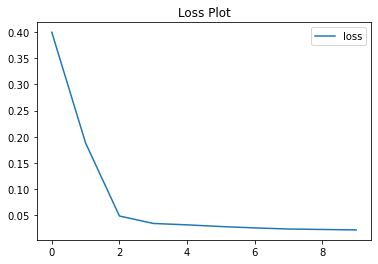

LSTM Model Test MSE: 0.001
LSTM Model Test RMSE: 0.023


c:\Users\raimu\anaconda3\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


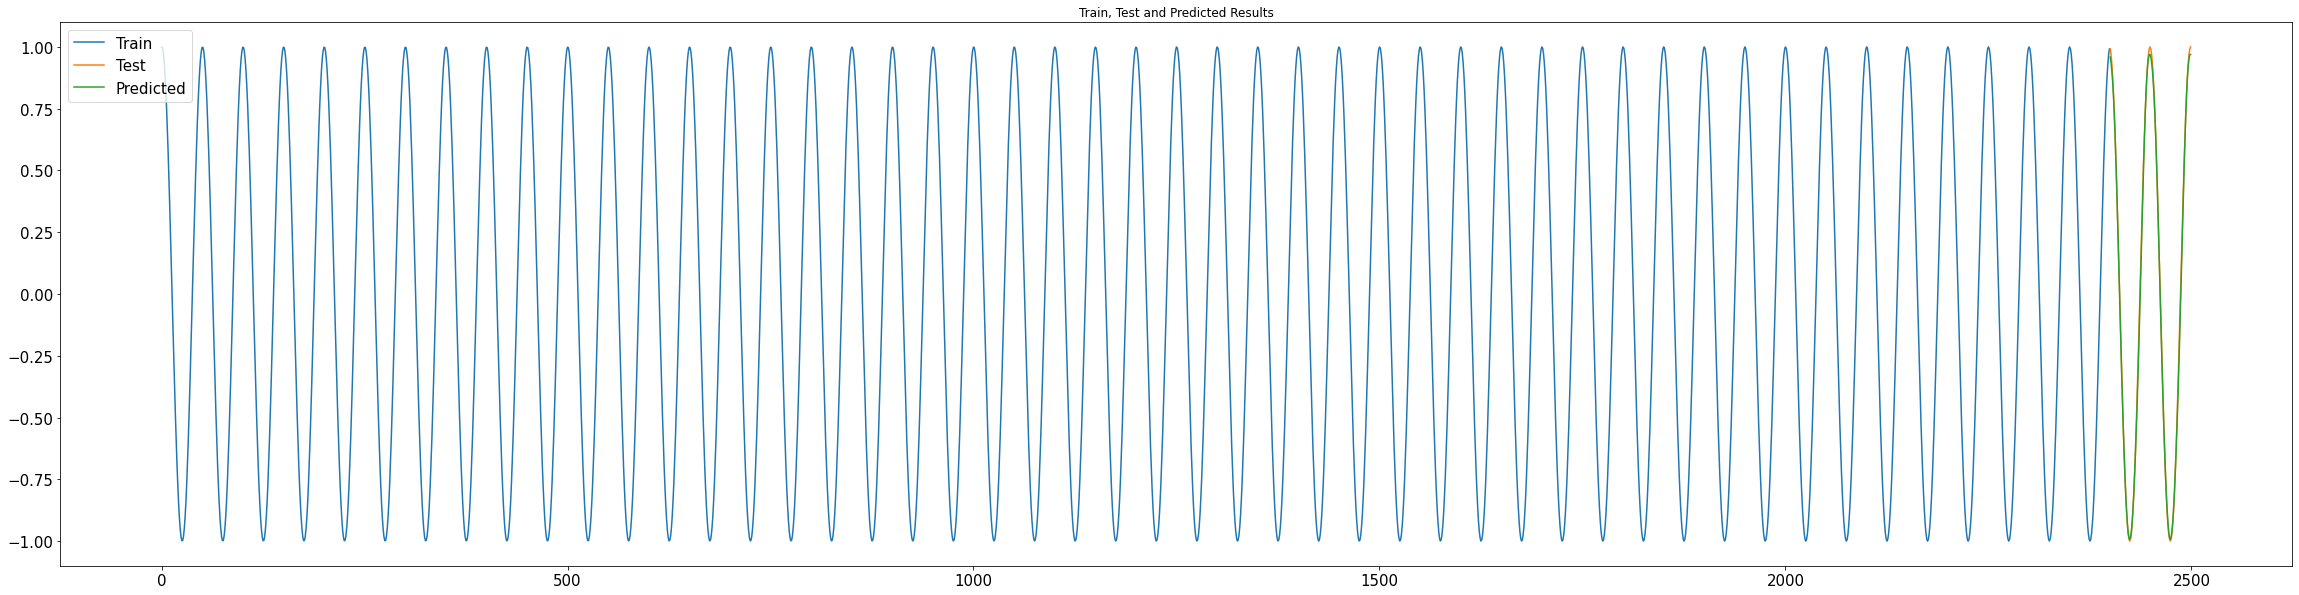

In [52]:
lstm(X_train_1, y_train_1, X_test_1, y_test_1, 10)

### 1.2.1.2 Second split:

LSTM Model contructed with 3 hidden layers of 12 neurons:

Currently fitting the model with the training set with 10  epochs:
Epoch 1/10
79/79 [==============================] - 6s 11ms/step - loss: 0.4107 - mean_absolute_error: 0.5753
Epoch 2/10
79/79 [==============================] - 1s 11ms/step - loss: 0.1497 - mean_absolute_error: 0.3218
Epoch 3/10
79/79 [==============================] - 1s 11ms/step - loss: 0.0439 - mean_absolute_error: 0.1641
Epoch 4/10
79/79 [==============================] - 1s 11ms/step - loss: 0.0326 - mean_absolute_error: 0.1417
Epoch 5/10
79/79 [==============================] - 1s 11ms/step - loss: 0.0302 - mean_absolute_error: 0.1370
Epoch 6/10
79/79 [==============================] - 1s 11ms/step - loss: 0.0259 - mean_absolute_error: 0.1268
Epoch 7/10
79/79 [==============================] - 1s 11ms/step - loss: 0.0253 - mean_absolute_error: 0.1242
Epoch 8/10
79/79 [==============================] - 1s 11ms/step - loss: 0.0237 - mean_absolute_error: 0

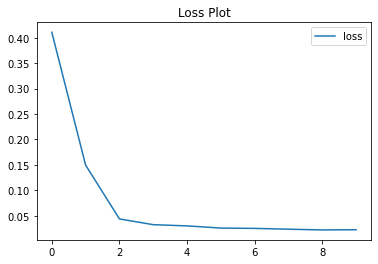

LSTM Model Test MSE: 0.002
LSTM Model Test RMSE: 0.040


c:\Users\raimu\anaconda3\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


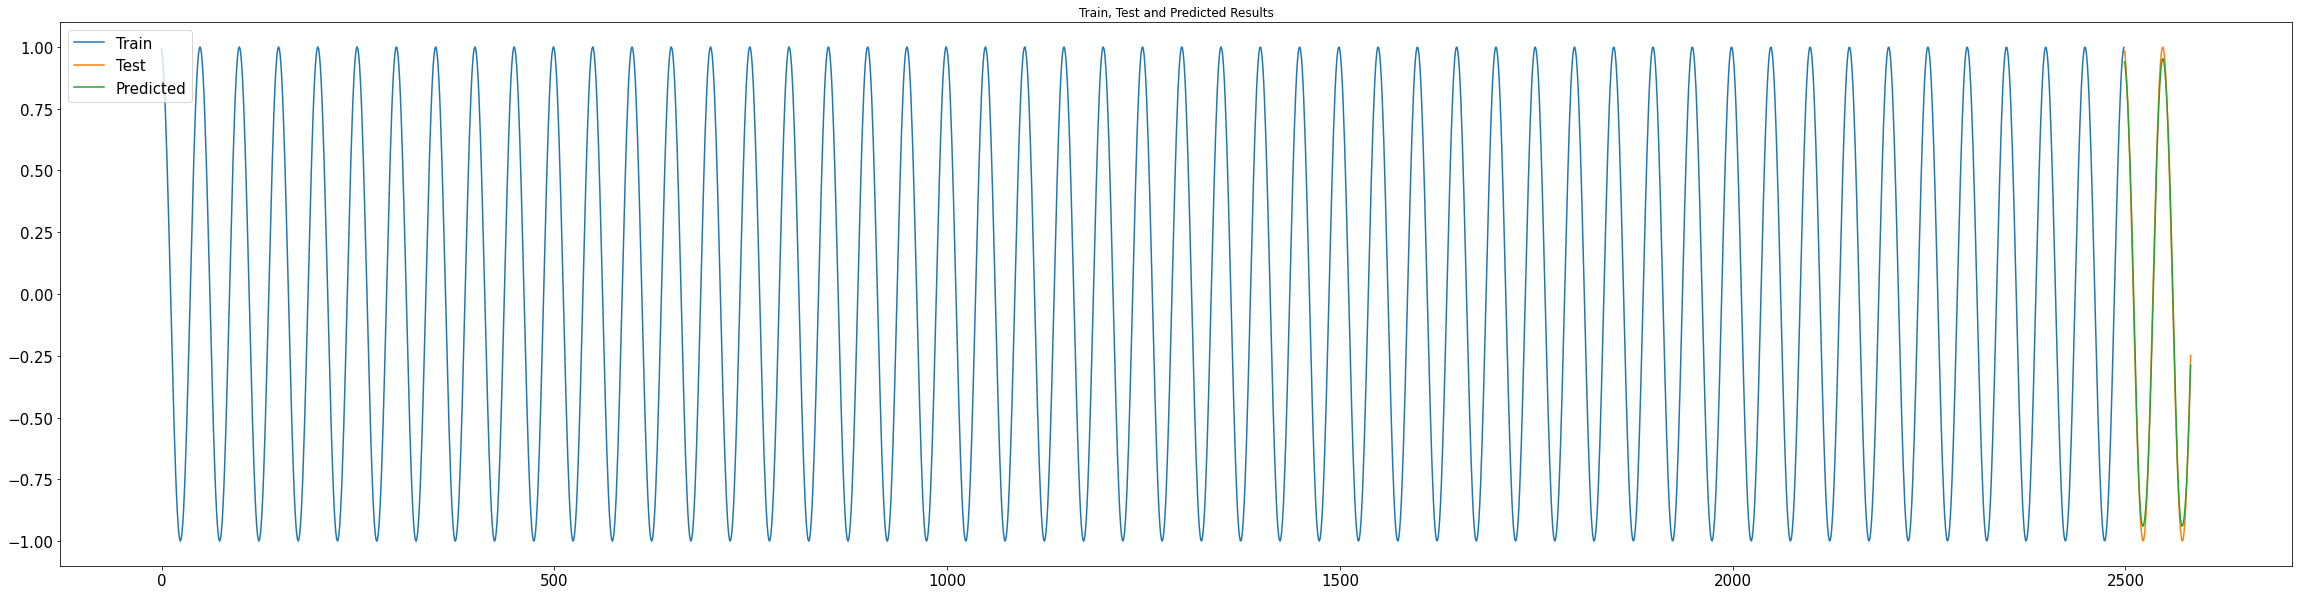

In [53]:
lstm(X_train_2, y_train_2, X_test_2, y_test_2, 10)

### 1.2.2. FTLFN Model

### 1.2.2.1. First split:

FTLFN Model contructed with 12 neurons:

Currently fitting the model with the training set with 10  epochs:
75/75 [==============================] - 0s 1ms/step - loss: 0.5008 - mean_absolute_error: 0.6369
Repeat 0) TrainMSE=0.498181, TestMSE=0.497421 

Currently fitting the model with the training set with 10  epochs:
75/75 [==============================] - 0s 1ms/step - loss: 0.5006 - mean_absolute_error: 0.6369
Repeat 1) TrainMSE=0.498858, TestMSE=0.498144 

Currently fitting the model with the training set with 10  epochs:
75/75 [==============================] - 0s 1ms/step - loss: 0.5008 - mean_absolute_error: 0.6369
Repeat 2) TrainMSE=0.498903, TestMSE=0.498104 

Currently fitting the model with the training set with 10  epochs:
75/75 [==============================] - 0s 1ms/step - loss: 0.5007 - mean_absolute_error: 0.6369
Repeat 3) TrainMSE=0.498708, TestMSE=0.497732 

Currently fitting the model with the training set with 10  epochs:
75/75 [==============================] -

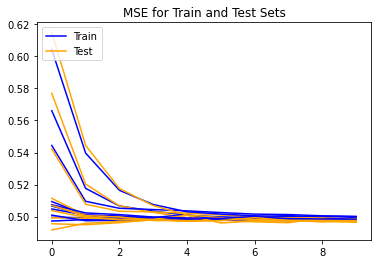

In [54]:
run_ftlfn(X_train_1, y_train_1, X_test_1, y_test_1, 10, 10)

### 1.2.2.2. Second split:

FTLFN Model contructed with 12 neurons:

Currently fitting the model with the training set with 10  epochs:
79/79 [==============================] - 0s 1ms/step - loss: 0.5003 - mean_absolute_error: 0.6366
Repeat 0) TrainMSE=0.498096, TestMSE=0.497003 

Currently fitting the model with the training set with 10  epochs:
79/79 [==============================] - 0s 2ms/step - loss: 0.5002 - mean_absolute_error: 0.6366
Repeat 1) TrainMSE=0.497040, TestMSE=0.496230 

Currently fitting the model with the training set with 10  epochs:
79/79 [==============================] - 0s 1ms/step - loss: 0.5004 - mean_absolute_error: 0.6367
Repeat 2) TrainMSE=0.497610, TestMSE=0.497277 

Currently fitting the model with the training set with 10  epochs:
79/79 [==============================] - 0s 1ms/step - loss: 0.5004 - mean_absolute_error: 0.6363
Repeat 3) TrainMSE=0.499183, TestMSE=0.499205 

Currently fitting the model with the training set with 10  epochs:
79/79 [==============================] -

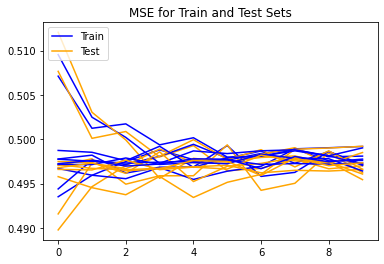

In [55]:
run_ftlfn(X_train_2, y_train_2, X_test_2, y_test_2, 10, 10)

### 1.3. Evaluating the performance of LSTM and FTLFN models with both splits and without noise


### 1.3. Inferring the evolution of LSTM and FTLFN learning process with noise

### 1.3.1. LSTM Model

### 1.3.1.1. First split:

LSTM Model contructed with 3 hidden layers of 12 neurons:

Currently fitting the model with the training set with 10  epochs:
Epoch 1/10
75/75 [==============================] - 4s 8ms/step - loss: 0.3721 - mean_absolute_error: 0.5503
Epoch 2/10
75/75 [==============================] - 1s 7ms/step - loss: 0.1443 - mean_absolute_error: 0.3182
Epoch 3/10
75/75 [==============================] - 1s 8ms/step - loss: 0.0469 - mean_absolute_error: 0.1707
Epoch 4/10
75/75 [==============================] - 1s 8ms/step - loss: 0.0382 - mean_absolute_error: 0.1546
Epoch 5/10
75/75 [==============================] - 1s 7ms/step - loss: 0.0348 - mean_absolute_error: 0.1492
Epoch 6/10
75/75 [==============================] - 1s 7ms/step - loss: 0.0284 - mean_absolute_error: 0.1336
Epoch 7/10
75/75 [==============================] - 1s 7ms/step - loss: 0.0273 - mean_absolute_error: 0.1292
Epoch 8/10
75/75 [==============================] - 1s 7ms/step - loss: 0.0260 - mean_absolute_error: 0.1266
Ep

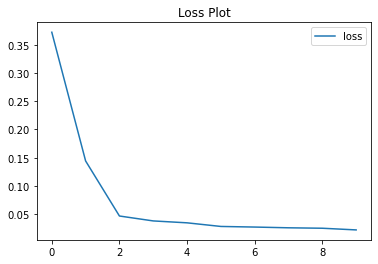

LSTM Model Test MSE: 0.001
LSTM Model Test RMSE: 0.038


c:\Users\raimu\anaconda3\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


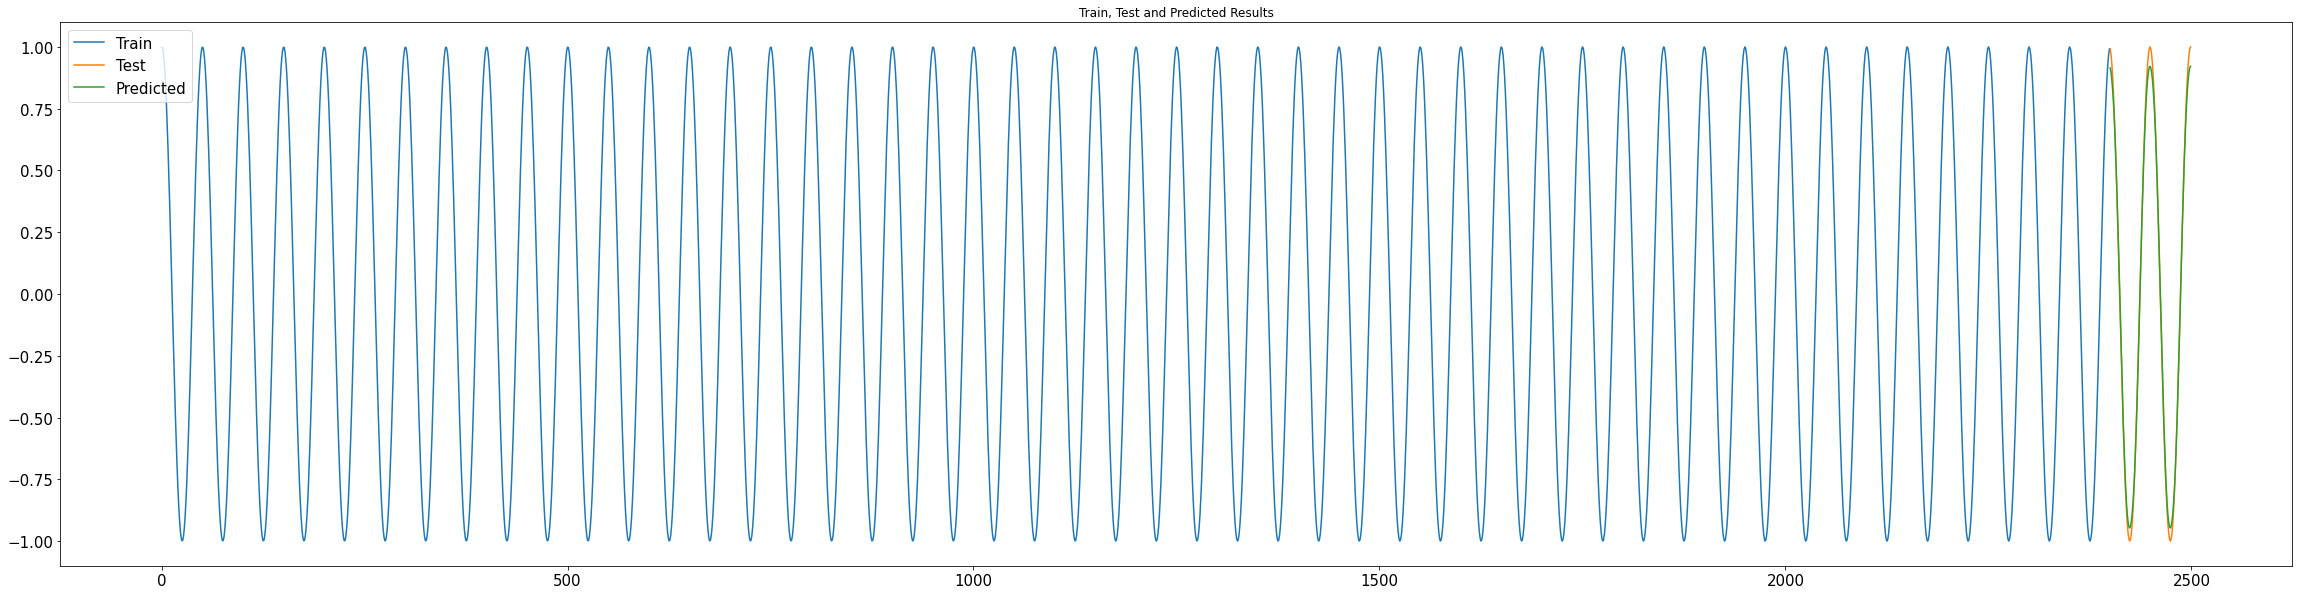

In [56]:
lstm(X_train_1, y_train_1, X_test_1, y_test_1, 10, True)

### 1.3.1.2. Second split:

LSTM Model contructed with 3 hidden layers of 12 neurons:

Currently fitting the model with the training set with 10  epochs:
Epoch 1/10
79/79 [==============================] - 6s 12ms/step - loss: 0.3648 - mean_absolute_error: 0.5439
Epoch 2/10
79/79 [==============================] - 1s 11ms/step - loss: 0.1222 - mean_absolute_error: 0.2895
Epoch 3/10
79/79 [==============================] - 1s 13ms/step - loss: 0.0431 - mean_absolute_error: 0.1642
Epoch 4/10
79/79 [==============================] - 1s 13ms/step - loss: 0.0347 - mean_absolute_error: 0.1460
Epoch 5/10
79/79 [==============================] - 1s 13ms/step - loss: 0.0299 - mean_absolute_error: 0.1357
Epoch 6/10
79/79 [==============================] - 1s 12ms/step - loss: 0.0257 - mean_absolute_error: 0.1251
Epoch 7/10
79/79 [==============================] - 1s 11ms/step - loss: 0.0236 - mean_absolute_error: 0.1194
Epoch 8/10
79/79 [==============================] - 1s 12ms/step - loss: 0.0226 - mean_absolute_error: 0

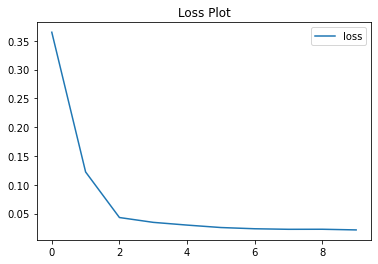

LSTM Model Test MSE: 0.001
LSTM Model Test RMSE: 0.032


c:\Users\raimu\anaconda3\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


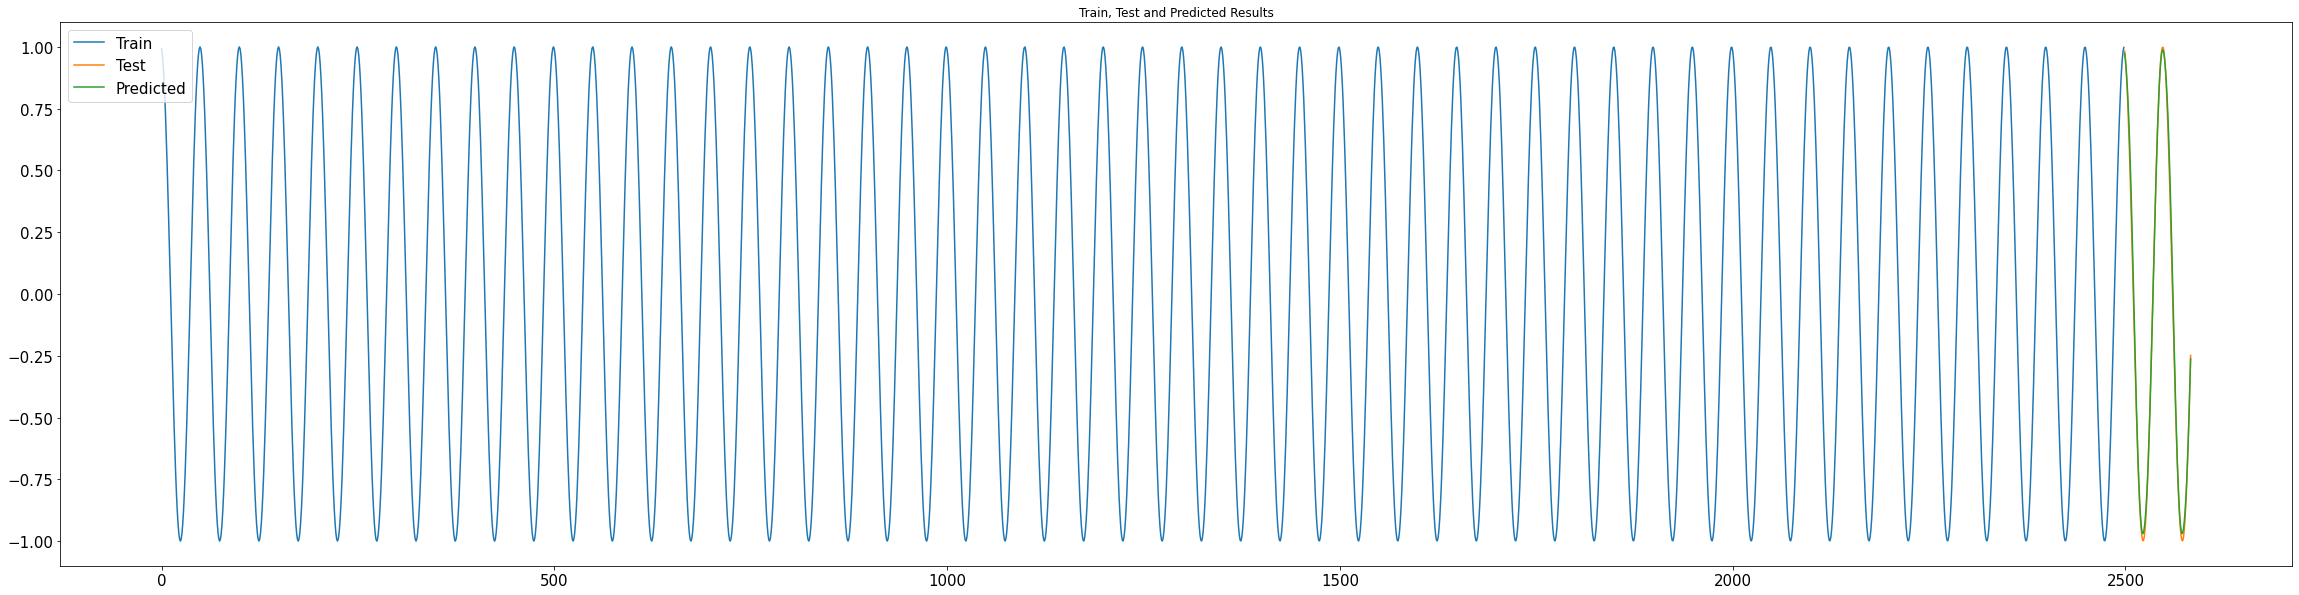

In [57]:
lstm(X_train_2, y_train_2, X_test_2, y_test_2, 10, True)

### 1.3.2. FTLFN Model

### 1.3.2.1. First Split:

FTLFN Model contructed with 12 neurons:

Currently fitting the model with the training set with 10  epochs:
75/75 [==============================] - 0s 1ms/step - loss: 0.5005 - mean_absolute_error: 0.6371
Repeat 0) TrainMSE=0.498163, TestMSE=0.497425 

Currently fitting the model with the training set with 10  epochs:
75/75 [==============================] - 0s 1ms/step - loss: 0.5006 - mean_absolute_error: 0.6368
Repeat 1) TrainMSE=0.498795, TestMSE=0.498039 

Currently fitting the model with the training set with 10  epochs:
75/75 [==============================] - 0s 1ms/step - loss: 0.5014 - mean_absolute_error: 0.6366
Repeat 2) TrainMSE=0.499744, TestMSE=0.499868 

Currently fitting the model with the training set with 10  epochs:
75/75 [==============================] - 0s 1ms/step - loss: 0.5012 - mean_absolute_error: 0.6370
Repeat 3) TrainMSE=0.498400, TestMSE=0.497575 

Currently fitting the model with the training set with 10  epochs:
75/75 [==============================] -

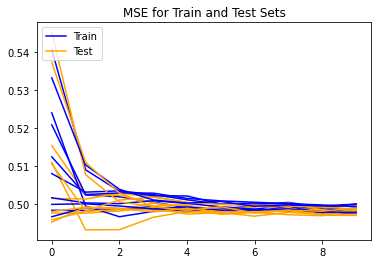

In [58]:
run_ftlfn(X_train_1, y_train_1, X_test_1, y_test_1, 10, 10, True)

### 1.3.2.2. Second Split

FTLFN Model contructed with 12 neurons:

Currently fitting the model with the training set with 10  epochs:
79/79 [==============================] - 0s 1ms/step - loss: 0.5002 - mean_absolute_error: 0.6365
Repeat 0) TrainMSE=0.497834, TestMSE=0.497131 

Currently fitting the model with the training set with 10  epochs:
79/79 [==============================] - 0s 1ms/step - loss: 0.5003 - mean_absolute_error: 0.6367
Repeat 1) TrainMSE=0.497478, TestMSE=0.496908 

Currently fitting the model with the training set with 10  epochs:
79/79 [==============================] - 0s 1ms/step - loss: 0.4999 - mean_absolute_error: 0.6363
Repeat 2) TrainMSE=0.497218, TestMSE=0.496321 

Currently fitting the model with the training set with 10  epochs:
79/79 [==============================] - 0s 1ms/step - loss: 0.4999 - mean_absolute_error: 0.6363
Repeat 3) TrainMSE=0.496100, TestMSE=0.494263 

Currently fitting the model with the training set with 10  epochs:
79/79 [==============================] -

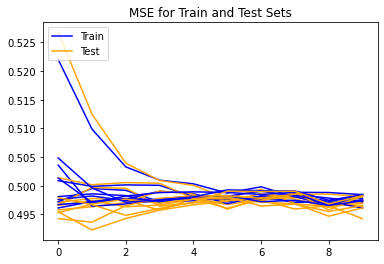

In [59]:
run_ftlfn(X_train_2, y_train_2, X_test_2, y_test_2, 10, 10, True)

### 1.3.3. Evaluating the performance of LSTM and FTLFN models with both splits and with noise

## Problem 2

We defined a time series using the output of the following autoregression model with a time delay of 12, generating 5000 data points.

**Autoregression model:**<p>

![](autoregression_model.JPG)

α1 = 0.6, α2= -0.54, α3= -0.44 <p>

We subset the timeseries dataset in two distinct manners, in order to evaluate the performances when performed with each model (LSTM and FTLFN) with:
 * Gaussin Noise N(0,0.01)
 * 50 epochs
 
<p>

**Splits:**
  * The first 2400 data points and test with data points 2401 to 2500
  * Data points 2401 to 4900 and test with data points 4901 to 5000

### 2.1. Creation of a time series:

In [60]:
data = [5,6,3]

for i in range(4997):
    out = (0.6*data[i+2]) + (-0.54*data[i+1]) + (-0.44*data[i]) #+ 0.01 (U)
    data.append(out)

print(len(data))

5000


Adding a filter (time delay) of 12 to the time series:

In [61]:
X = []
y = []
lag = 12

for i in range(lag, 4999):
   X.append(data[i-lag:i])
   y.append(data[i])

X = np.expand_dims(X, axis = 2)
y = np.array(y)

Split Data:

- Training with the first 2400 data points and testing with data points 2401 to 2501 (First split);
  
- Training from data points 2401 to 4900 and testing with data points 4901 to the last data point (Second split).

In [62]:
X_train_1 = X[:2400]
y_train_1 = y[:2400]
X_test_1  = X[2401:2501]
y_test_1  = y[2401:2501]

X_train_2 = X[2401:4900]
y_train_2 = y[2401:4900]
X_test_2  = X[4901:-1]
y_test_2  = y[4901:-1]

print("Shape of sets: \n")
print("--> First Split Train and Test sets:")
print("X_train_1: ", X_train_1.shape)
print("y_train_1: ", y_train_1.shape)
print("X_test_1: ", X_test_1.shape)
print("y_test_1: ", y_test_1.shape,"\n")

print("--> Second Split Train and Test sets:")
print("X_train_2: ", X_train_2.shape)
print("y_train_2: ", y_train_2.shape)
print("X_test_2: ", X_test_2.shape)
print("y_test_2: ", y_test_2.shape)

Shape of sets: 

--> First Split Train and Test sets:
X_train_1:  (2400, 12, 1)
y_train_1:  (2400,)
X_test_1:  (100, 12, 1)
y_test_1:  (100,) 

--> Second Split Train and Test sets:
X_train_2:  (2499, 12, 1)
y_train_2:  (2499,)
X_test_2:  (85, 12, 1)
y_test_2:  (85,)


### 2.2. Inferring the evolution of LSTM and FTLFN learning process with noise

### 2.2.1. LSTM Model 

### 2.2.1.1. First split:

LSTM Model contructed with 3 hidden layers of 12 neurons:

Currently fitting the model with the training set with 50  epochs:
Epoch 1/50
75/75 [==============================] - 5s 8ms/step - loss: 5.5984 - mean_absolute_error: 1.9094
Epoch 2/50
75/75 [==============================] - 1s 7ms/step - loss: 3.6560 - mean_absolute_error: 1.4784
Epoch 3/50
75/75 [==============================] - 1s 7ms/step - loss: 1.4183 - mean_absolute_error: 0.8711
Epoch 4/50
75/75 [==============================] - 1s 7ms/step - loss: 0.8185 - mean_absolute_error: 0.6566
Epoch 5/50
75/75 [==============================] - 1s 7ms/step - loss: 0.6259 - mean_absolute_error: 0.5718
Epoch 6/50
75/75 [==============================] - 1s 7ms/step - loss: 0.5231 - mean_absolute_error: 0.5316
Epoch 7/50
75/75 [==============================] - 1s 8ms/step - loss: 0.5057 - mean_absolute_error: 0.5258
Epoch 8/50
75/75 [==============================] - 1s 8ms/step - loss: 0.4518 - mean_absolute_error: 0.4917
Ep

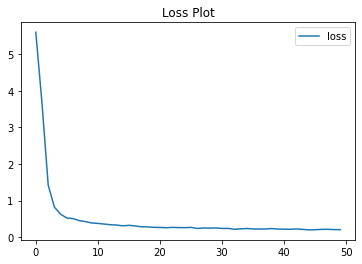

LSTM Model Test MSE: 0.002
LSTM Model Test RMSE: 0.043


c:\Users\raimu\anaconda3\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


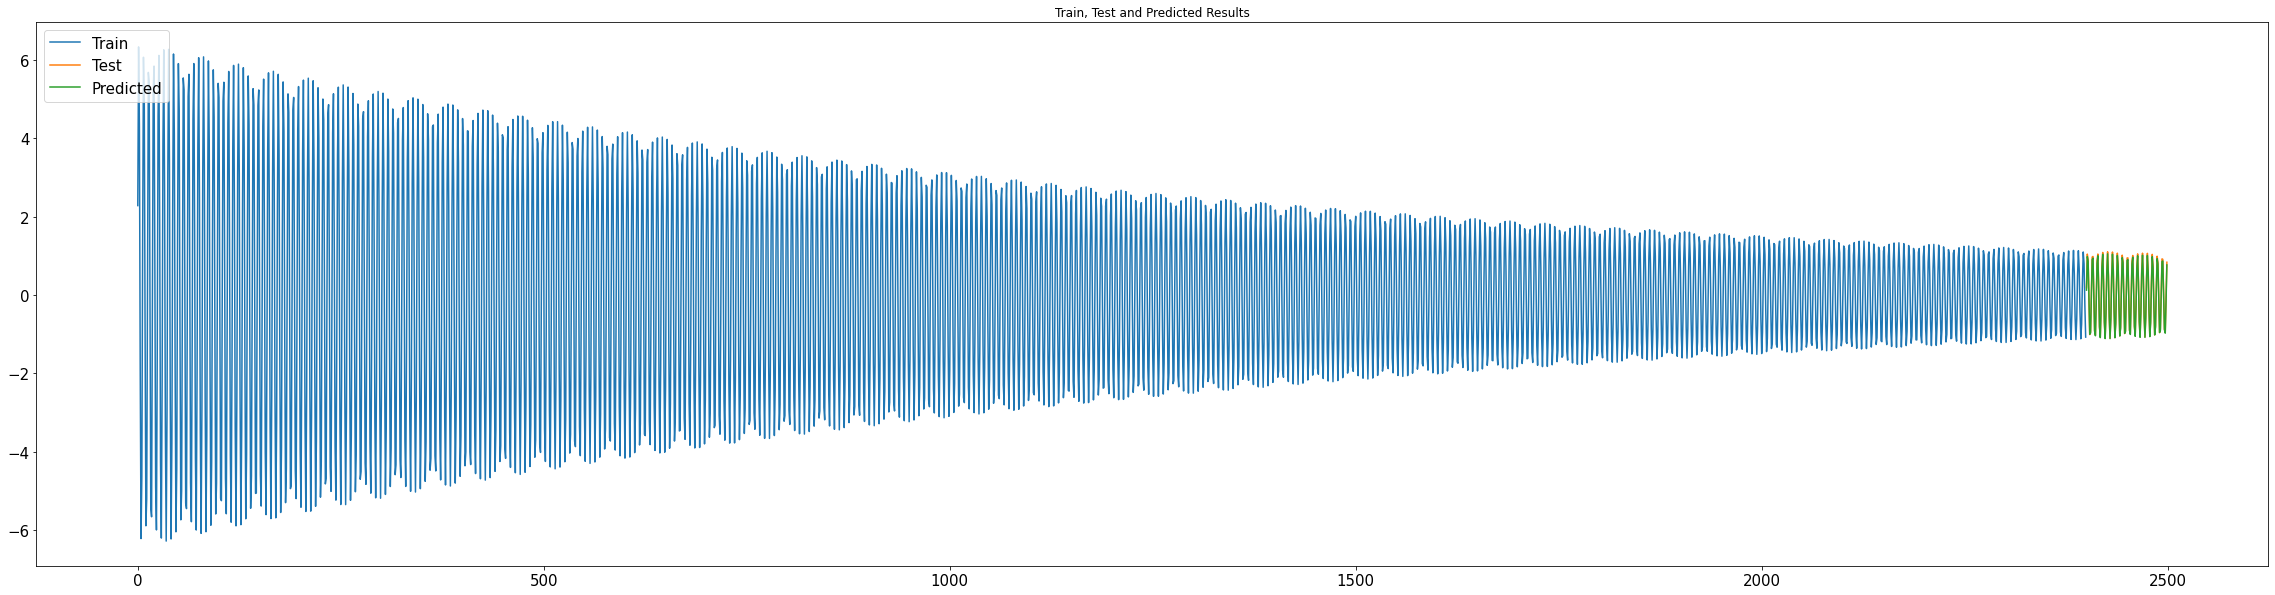

In [63]:
lstm(X_train_1, y_train_1, X_test_1, y_test_1, 50, True, 0.01)

### 2.2.1.1. Second split:

LSTM Model contructed with 3 hidden layers of 12 neurons:

Currently fitting the model with the training set with 50  epochs:
Epoch 1/50
79/79 [==============================] - 6s 11ms/step - loss: 0.1624 - mean_absolute_error: 0.3226
Epoch 2/50
79/79 [==============================] - 1s 11ms/step - loss: 0.0946 - mean_absolute_error: 0.2384
Epoch 3/50
79/79 [==============================] - 1s 12ms/step - loss: 0.0503 - mean_absolute_error: 0.1693
Epoch 4/50
79/79 [==============================] - 1s 11ms/step - loss: 0.0354 - mean_absolute_error: 0.1407
Epoch 5/50
79/79 [==============================] - 1s 12ms/step - loss: 0.0315 - mean_absolute_error: 0.1314
Epoch 6/50
79/79 [==============================] - 1s 12ms/step - loss: 0.0261 - mean_absolute_error: 0.1203
Epoch 7/50
79/79 [==============================] - 1s 11ms/step - loss: 0.0242 - mean_absolute_error: 0.1164
Epoch 8/50
79/79 [==============================] - 1s 12ms/step - loss: 0.0216 - mean_absolute_error: 0

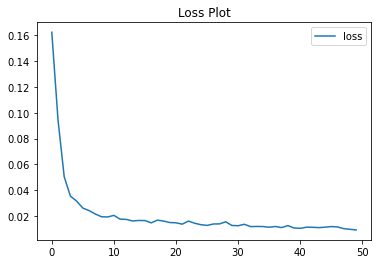

LSTM Model Test MSE: 0.001
LSTM Model Test RMSE: 0.032


c:\Users\raimu\anaconda3\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


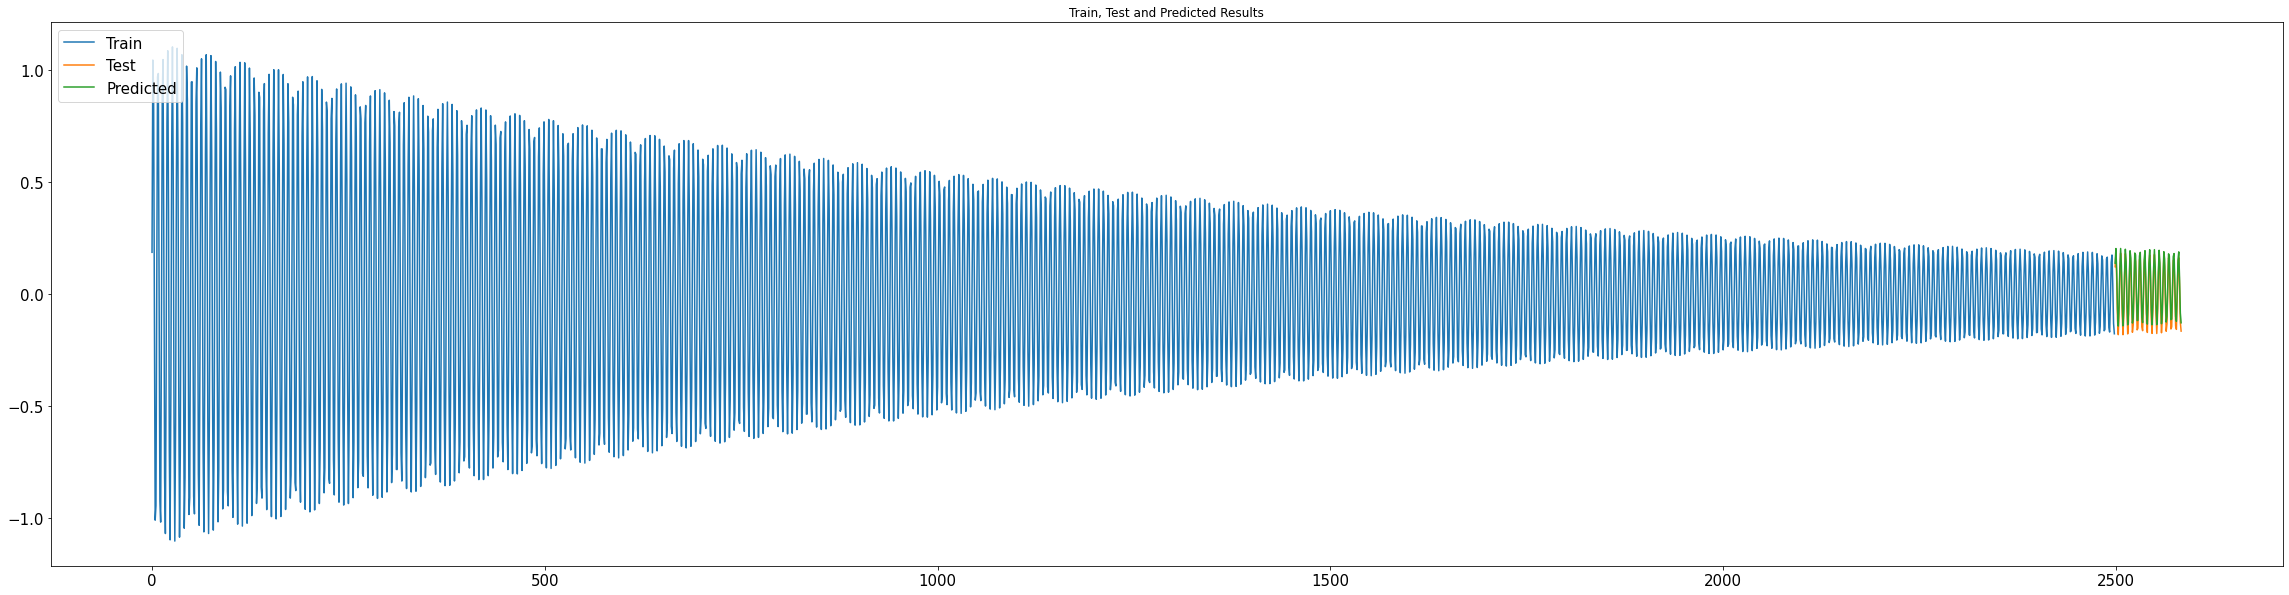

In [64]:
lstm(X_train_2, y_train_2, X_test_2, y_test_2, 50, True, 0.01)

### 2.2.2. FTLFN Model 

### 2.2.2.1. First split:

FTLFN Model contructed with 12 neurons:

Currently fitting the model with the training set with 50  epochs:
75/75 [==============================] - 0s 1ms/step - loss: 5.7847 - mean_absolute_error: 1.9431
Repeat 0) TrainMSE=5.782618, TestMSE=0.587696 

Currently fitting the model with the training set with 50  epochs:
75/75 [==============================] - 0s 1ms/step - loss: 5.7871 - mean_absolute_error: 1.9435
Repeat 1) TrainMSE=5.782750, TestMSE=0.587712 

Currently fitting the model with the training set with 50  epochs:
75/75 [==============================] - 0s 1ms/step - loss: 5.7866 - mean_absolute_error: 1.9435
Repeat 2) TrainMSE=5.784755, TestMSE=0.588221 

Currently fitting the model with the training set with 50  epochs:
75/75 [==============================] - 0s 1ms/step - loss: 5.7845 - mean_absolute_error: 1.9429
Repeat 3) TrainMSE=5.783252, TestMSE=0.587836 

Currently fitting the model with the training set with 50  epochs:
75/75 [==============================] -

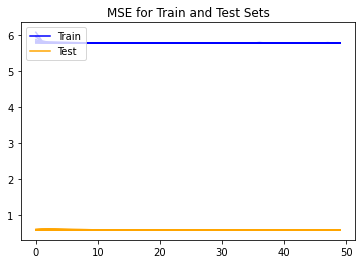

In [65]:
run_ftlfn(X_train_1, y_train_1, X_test_1, y_test_1,10, 50, True, 0.01)

### 2.2.2.2. Second split:

FTLFN Model contructed with 12 neurons:

Currently fitting the model with the training set with 50  epochs:
79/79 [==============================] - 0s 1ms/step - loss: 0.1702 - mean_absolute_error: 0.3307
Repeat 0) TrainMSE=0.170126, TestMSE=0.587880 

Currently fitting the model with the training set with 50  epochs:
79/79 [==============================] - 0s 1ms/step - loss: 0.1703 - mean_absolute_error: 0.3308
Repeat 1) TrainMSE=0.170191, TestMSE=0.587655 

Currently fitting the model with the training set with 50  epochs:
79/79 [==============================] - 0s 1ms/step - loss: 0.1703 - mean_absolute_error: 0.3305
Repeat 2) TrainMSE=0.170190, TestMSE=0.587680 

Currently fitting the model with the training set with 50  epochs:
79/79 [==============================] - 0s 2ms/step - loss: 0.1704 - mean_absolute_error: 0.3309
Repeat 3) TrainMSE=0.170345, TestMSE=0.587820 

Currently fitting the model with the training set with 50  epochs:
79/79 [==============================] -

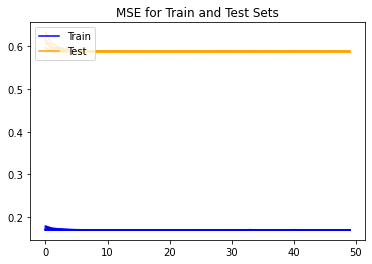

In [66]:
run_ftlfn(X_train_2, y_train_2, X_test_2, y_test_2,10, 50, True, 0.01)

### 2.3. Evaluating the performance of LSTM and FTLFN models with both splits and with noise